In [ ]:
def sort_by_frequency(arr):
    freq_dict = {}
    for i in arr:
        if i in freq_dict:
            freq_dict[i] += 1
        else:
            freq_dict[i] = 1

    sorted_arr = sorted(arr, key=lambda x: (-freq_dict[x], arr.index(x)))
    return sorted_arr

In [ ]:
sort_by_frequency([4, 5, 6, 5, 4, 3])

[4, 4, 5, 5, 6, 3]

In [ ]:
import os
import sys
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [ ]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Number of devices:  8


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

## **Data Preprocessing**

In [ ]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa as lr
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1T0ny4mxPhCfMO9NGj_xylZbS4a2Lh7Ju' #<-- You add in here the id from you google drive file, you can find it


download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('speech-emotion-recognition-en.zip')

In [ ]:
!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [ ]:
def LoadAudio(Crema):
    emotions = []
    Audio_List=[]
    samp_freq=[]
    paths = []

    for wav in os.listdir(Crema):
        path=Crema+"/"+wav
        paths.append(path)
        audio,sampling_freq=lr.load(path,sr=22050)         #loads the audio data from the current file with a sampling rate of 22050 Hz.
        yt, index = lr.effects.trim(audio, top_db=60)     #trims the silent portions of the audio (with a threshold of -60 decibels)

        if len(yt) > (3*22050):    #checks if the trimmed audio is longer than 3 seconds.
            yt = yt[:3*22050]  #truncates the trimmed audio to 3 seconds if it is longer than that.
        else:
            padding = (3*22050) - len(yt) #calculates the amount of padding needed to make the audio exactly 3 seconds long.
            offset = padding // 3        #calculates the amount of padding to add to the beginning and end of the audio
            yt = np.pad(yt, (offset,3*22050- len(yt) - offset), 'constant')   # pads the audio with zeros to make it 3 seconds long.

        mean = np.mean(yt)
        std = np.std(yt)
        out = np.ones( (len(yt)) )
        yt= np.divide((yt - mean),std,out=out, where=std!=0)    #normalizes the audio data using z-score normalization.

        Audio_List.append(yt)
        samp_freq.append(sampling_freq)

        info = wav.partition(".wav")[0].split("_")    #extracts information about the current file from its filename.
        if info[2] == 'SAD':
            emotions.append(0)
        elif info[2] == 'ANG':
            emotions.append(1)
        elif info[2] == 'DIS':
            emotions.append(2)
        elif info[2] == 'FEA':
            emotions.append(3)
        elif info[2] == 'HAP':
            emotions.append(4)
        elif info[2] == 'NEU':
            emotions.append(5)
        else:
            emotions.append(6)

    return Audio_List,samp_freq,emotions, paths

In [ ]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Audio_List,samp_freq,Labels, paths =  LoadAudio('Crema')
emotions_df = pd.DataFrame(Labels, columns=['Emotions'])
paths_df = pd.DataFrame(paths, columns=['Paths'])
crema_df = pd.concat([emotions_df, paths_df], axis=1)
data_paths = crema_df

print(len(Audio_List))
print(len(Labels))

7442
7442


In [ ]:
def visualize(data, sample_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with '+str(emotion)+' emotion', size=15)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==0])[0]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "sad")
Audio(audio_path)

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==1])[1]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "angry")
Audio(audio_path)

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==2])[2]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "disgust")
Audio(audio_path)

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==3])[3]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "fear")
Audio(audio_path)

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==4])[4]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "happy")
Audio(audio_path)

In [ ]:
audio_path = np.array(crema_df.Paths[crema_df.Emotions==5])[5]
data, sample_rate = librosa.load(audio_path)
visualize(data, sample_rate, "neutral")
Audio(audio_path)

##**Creating Feature Space**

In [ ]:
energy = np.sum(Audio_List[70] ** 2, axis=0) / len(Audio_List[50])
energy

1.0000000077630173

In [ ]:
rms = np.mean(lr.feature.rms(y=Audio_List[50]).T, axis=0)
rms

array([0.6267414], dtype=float32)

In [ ]:
def zcr(data, frame_length=1024, hop_length=512):
    zcr = lr.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)

    return np.squeeze(zcr)

In [ ]:
def extract_features(Audio_List, samp_freq ,frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,zcr(Audio_List, frame_length, hop_length)))                         #calculates the ZCR for each audio signal in Audio_List using the zcr() helper function and appends the results to the result array using NumPy's hstack() function.

    rms = np.mean(lr.feature.rms(y=Audio_List).T, axis=0)                                            #calculates the root-mean-square (RMS) energy of each audio signal in Audio_List using librosa.feature.rms() and takes the mean across all frames. The resulting array has the same length as the number of audio signals in Audio_List.
    result = np.hstack((result, rms))                                                                                             #appends the RMS energy values to the result array using hstack().

    stft = np.abs(lr.stft(Audio_List))                                                                                            #calculates the short-time Fourier transform (STFT) magnitude of each audio signal in Audio_List using librosa.stft().
    chroma_stft = np.mean(lr.feature.chroma_stft(S=stft, sr=22050).T, axis=0)                                                #calculates the chroma feature (which represents the distribution of 12 pitch classes in the audio) for each audio signal in Audio_List using
                                                                                                                            #librosa.feature.chroma_stft() and takes the mean across all frames. The resulting array has length 12.
    result = np.hstack((result, chroma_stft)) #append

    mfcc = np.mean(lr.feature.mfcc(y=Audio_List, sr=22050).T, axis=0)                                             #calculates the Mel-frequency cepstral coefficients (MFCCs) for each audio signal in Audio_List using librosa.feature.mfcc() and takes the mean across all frames. The resulting array has length 20 by default.
    result = np.hstack((result, mfcc)) #append

    return result

##**Building the Model**

In [ ]:
train_data, test_data, labels_train1D, labels_test1D = train_test_split(Audio_List,Labels, test_size=0.30, random_state=42)
train_data,val_data, labels_train1D, labels_val1D = train_test_split(train_data,labels_train1D, test_size=0.05, random_state=42)
print(len(train_data))
print(len(val_data))
print(len(test_data))

4948
261
2233


###data augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [ ]:
train_Aug=[]
for i in range(len(train_data)):
  train_Aug.append(train_data[i])

for i in range(len(train_data)):
  noise_data = noise(train_data[i])
  train_Aug.append(noise_data)
  labels_train1D.append(labels_train1D[i])

for i in range(len(train_data)):
  shift_data = shift(train_data[i])
  train_Aug.append(shift_data)
  labels_train1D.append(labels_train1D[i])

print(len(train_Aug))
print(len(labels_train1D))
print(len(train_data))

14844
14844
4948


In [ ]:
features_aug=[]
for i in range(len(train_Aug)):

    res1 = extract_features(train_Aug[i],22050)
    result = np.array(res1)
    features_aug.append(result)

features_val=[]
for i in range(len(val_data)):

    res1 = extract_features(val_data[i],22050)
    result = np.array(res1)
    features_val.append(result)

features_test=[]
for i in range(len(test_data)):

    res1 = extract_features(test_data[i],22050)
    result = np.array(res1)
    features_test.append(result)

In [ ]:
features_aug = np.array(features_aug)
features_aug = features_aug[:,:,np.newaxis]
print(features_aug.shape)

features_val = np.array(features_val)
features_val = features_val[:,:,np.newaxis]
print(features_val.shape)

features_test = np.array(features_test)
features_test = features_test[:,:,np.newaxis]
print(features_test.shape)

(14844, 163, 1)
(261, 163, 1)
(2233, 163, 1)


###feature extraction

In [ ]:
features=[]
for i in range(len(train_data)):

    res1 = extract_features(train_data[i],22050)
    result = np.array(res1)
    features.append(result)

features_val=[]
for i in range(len(val_data)):

    res1 = extract_features(val_data[i],22050)
    result = np.array(res1)
    features_val.append(result)

features_test=[]
for i in range(len(test_data)):

    res1 = extract_features(test_data[i],22050)
    result = np.array(res1)
    features_test.append(result)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
#In CNNs, the input to the model is typically a 3-dimensional array of shape (samples, height, width, channels),
features = np.array(features)
features = features[:,:,np.newaxis]
print(features.shape)

features_val = np.array(features_val)
features_val = features_val[:,:,np.newaxis]
print(features_val.shape)

features_test = np.array(features_test)
features_test = features_test[:,:,np.newaxis]
print(features_test.shape)

(4948, 163, 1)
(261, 163, 1)
(2233, 163, 1)


### 1D Models (without Augmentation)

In [ ]:
import keras.api._v2.keras as keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn import preprocessing
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(128, kernel_size=(3), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history = model.fit(np.array(features),np.array(labels_train1D),batch_size=32,epochs=100,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/100
155/155 [==============================] - 13s 54ms/step - loss: 2.3029 - accuracy: 0.1991 - val_loss: 1.7603 - val_accuracy: 0.2375 - lr: 1.0000e-04
Epoch 2/100
155/155 [==============================] - 8s 53ms/step - loss: 1.8103 - accuracy: 0.2158 - val_loss: 1.7518 - val_accuracy: 0.2337 - lr: 1.0000e-04
Epoch 3/100
155/155 [==============================] - 8s 53ms/step - loss: 1.7484 - accuracy: 0.2316 - val_loss: 1.7205 - val_accuracy: 0.2184 - lr: 1.0000e-04
Epoch 4/100
155/155 [==============================] - 8s 53ms/step - loss: 1.7342 - accuracy: 0.2361 - val_loss: 1.7127 - val_accuracy: 0.2682 - lr: 1.0000e-04
Epoch 5/100
155/155 [==============================] - 8s 53ms/step - loss: 1.7125 - accuracy: 0.2437 - val_loss: 1.7067 - val_accuracy: 0.2644 - lr: 1.0000e-04
Epoch 6/100
155/155 [==============================] - 8s 53ms/step - loss: 1.6970 - accuracy: 0.2551 - val_loss: 1.6985 - val_accuracy: 0.2720 - lr: 1.0000e-04
Epoch 7/100
155/155 [============

70/70 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.45      0.66      0.54       386
           1       0.57      0.68      0.62       392
           2       0.41      0.36      0.39       390
           3       0.32      0.08      0.13       363
           4       0.42      0.43      0.42       377
           5       0.36      0.42      0.39       325

    accuracy                           0.44      2233
   macro avg       0.42      0.44      0.41      2233
weighted avg       0.43      0.44      0.42      2233



val accuracy: 40.229883790016174
train accuracy: 43.73484253883362
test accuracy 44.37975817286162




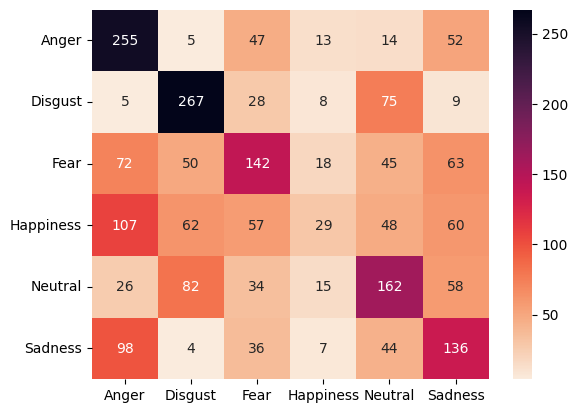

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(features), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))


model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_98 (Conv1D)          (None, 159, 512)          3072      
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 78, 512)          0         
 g1D)                                                            
                                                                 
 dropout_98 (Dropout)        (None, 78, 512)           0         
                                                                 
 conv1d_99 (Conv1D)          (None, 74, 256)           655616    
                                                                 
 max_pooling1d_90 (MaxPoolin  (None, 35, 256)          0         
 g1D)                                                            
                                                                 
 dropout_99 (Dropout)        (None, 35, 256)         

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history = model.fit(np.array(features),np.array(labels_train1D),batch_size=32,epochs=200,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/200
155/155 [==============================] - 8s 46ms/step - loss: 2.0949 - accuracy: 0.1609 - val_loss: 2.0090 - val_accuracy: 0.1571 - lr: 1.0000e-04
Epoch 2/200
155/155 [==============================] - 7s 44ms/step - loss: 1.9783 - accuracy: 0.1785 - val_loss: 1.9679 - val_accuracy: 0.1724 - lr: 1.0000e-04
Epoch 3/200
155/155 [==============================] - 7s 44ms/step - loss: 1.9215 - accuracy: 0.2082 - val_loss: 1.9055 - val_accuracy: 0.1801 - lr: 1.0000e-04
Epoch 4/200
155/155 [==============================] - 7s 44ms/step - loss: 1.8776 - accuracy: 0.2217 - val_loss: 1.8891 - val_accuracy: 0.2452 - lr: 1.0000e-04
Epoch 5/200
155/155 [==============================] - 7s 45ms/step - loss: 1.8736 - accuracy: 0.2195 - val_loss: 1.8782 - val_accuracy: 0.2184 - lr: 1.0000e-04
Epoch 6/200
155/155 [==============================] - 7s 44ms/step - loss: 1.8491 - accuracy: 0.2308 - val_loss: 1.8449 - val_accuracy: 0.2567 - lr: 1.0000e-04
Epoch 7/200
155/155 [=============

70/70 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.38      0.79      0.51       386
           1       0.60      0.62      0.61       392
           2       0.40      0.35      0.38       390
           3       0.30      0.04      0.07       363
           4       0.41      0.35      0.38       377
           5       0.36      0.34      0.35       325

    accuracy                           0.42      2233
   macro avg       0.41      0.42      0.38      2233
weighted avg       0.41      0.42      0.39      2233



val accuracy: 36.39846742153168
train accuracy: 41.14793837070465
test accuracy 42.27496641289745




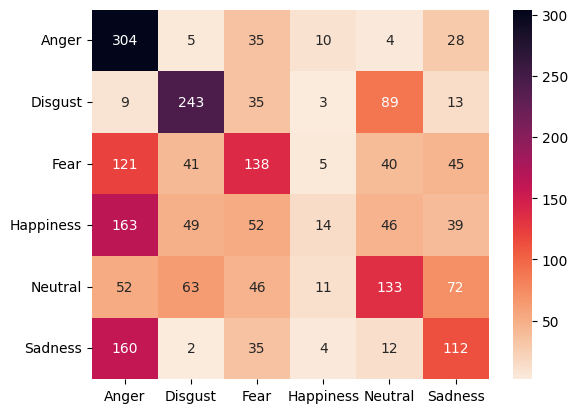

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(features), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))



model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_102 (Conv1D)         (None, 159, 512)          3072      
                                                                 
 max_pooling1d_93 (MaxPoolin  (None, 78, 512)          0         
 g1D)                                                            
                                                                 
 dropout_103 (Dropout)       (None, 78, 512)           0         
                                                                 
 conv1d_103 (Conv1D)         (None, 74, 512)           1311232   
                                                                 
 max_pooling1d_94 (MaxPoolin  (None, 35, 512)          0         
 g1D)                                                            
                                                                 
 dropout_104 (Dropout)       (None, 35, 512)         

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history = model.fit(np.array(features),np.array(labels_train1D),batch_size=32,epochs=200,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/200
155/155 [==============================] - 12s 66ms/step - loss: 2.1390 - accuracy: 0.2015 - val_loss: 1.7449 - val_accuracy: 0.1992 - lr: 1.0000e-04
Epoch 2/200
155/155 [==============================] - 10s 62ms/step - loss: 1.7696 - accuracy: 0.2268 - val_loss: 1.7252 - val_accuracy: 0.1762 - lr: 1.0000e-04
Epoch 3/200
155/155 [==============================] - 10s 63ms/step - loss: 1.7303 - accuracy: 0.2437 - val_loss: 1.7239 - val_accuracy: 0.2031 - lr: 1.0000e-04
Epoch 4/200
155/155 [==============================] - 10s 62ms/step - loss: 1.7104 - accuracy: 0.2458 - val_loss: 1.6996 - val_accuracy: 0.2644 - lr: 1.0000e-04
Epoch 5/200
155/155 [==============================] - 10s 63ms/step - loss: 1.6855 - accuracy: 0.2700 - val_loss: 1.7022 - val_accuracy: 0.2720 - lr: 1.0000e-04
Epoch 6/200
155/155 [==============================] - 10s 62ms/step - loss: 1.6695 - accuracy: 0.2795 - val_loss: 1.6606 - val_accuracy: 0.2989 - lr: 1.0000e-04
Epoch 7/200
155/155 [=======

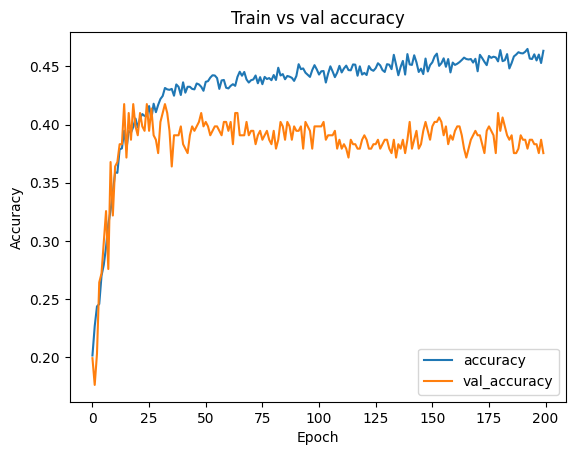

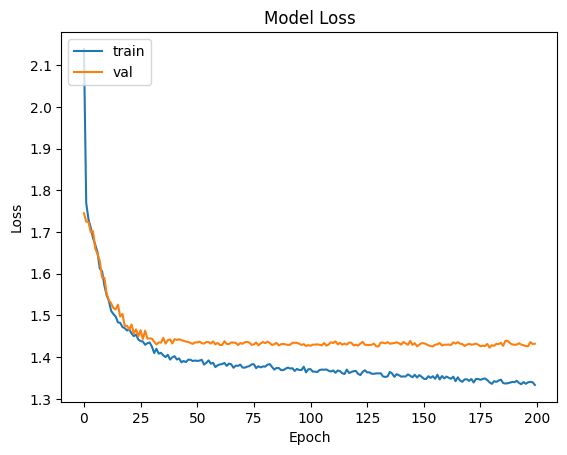

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

70/70 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       386
           1       0.62      0.67      0.64       392
           2       0.46      0.40      0.43       390
           3       0.34      0.12      0.18       363
           4       0.43      0.39      0.41       377
           5       0.38      0.63      0.47       325

    accuracy                           0.47      2233
   macro avg       0.46      0.47      0.45      2233
weighted avg       0.46      0.47      0.45      2233



val accuracy: 37.547892332077026
train accuracy: 46.422797441482544
test accuracy 47.1115091804747




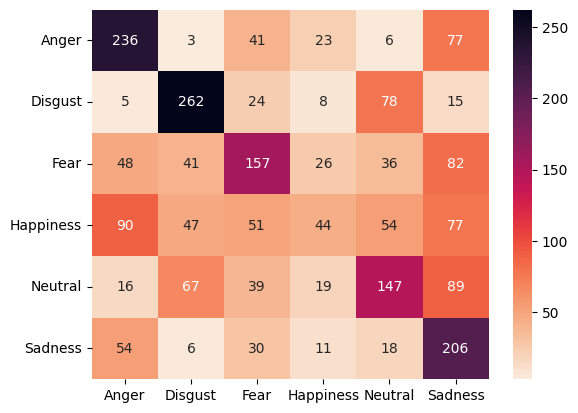

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(features), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

### 1D Models (with Augmentation)

In [ ]:
import keras.api._v2.keras as keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn import preprocessing
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

model = tf.keras.Sequential()
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))



model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 159, 512)          3072      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 512)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 78, 512)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 74, 512)           1311232   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 35, 512)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 35, 512)          

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history = model.fit(np.array(features_aug),np.array(labels_train1D),batch_size=32,epochs=200,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/200
464/464 [==============================] - 36s 65ms/step - loss: 1.8806 - accuracy: 0.2146 - val_loss: 1.7269 - val_accuracy: 0.2184 - lr: 1.0000e-04
Epoch 2/200
464/464 [==============================] - 29s 63ms/step - loss: 1.6880 - accuracy: 0.2659 - val_loss: 1.6852 - val_accuracy: 0.2644 - lr: 1.0000e-04
Epoch 3/200
464/464 [==============================] - 29s 63ms/step - loss: 1.6361 - accuracy: 0.2988 - val_loss: 1.6571 - val_accuracy: 0.3142 - lr: 1.0000e-04
Epoch 4/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5796 - accuracy: 0.3306 - val_loss: 1.6231 - val_accuracy: 0.3103 - lr: 1.0000e-04
Epoch 5/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5472 - accuracy: 0.3490 - val_loss: 1.6258 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 6/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5269 - accuracy: 0.3626 - val_loss: 1.6137 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 7/200
464/464 [=======

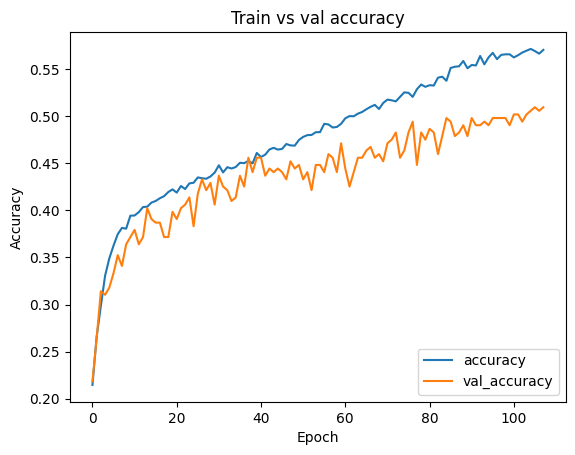

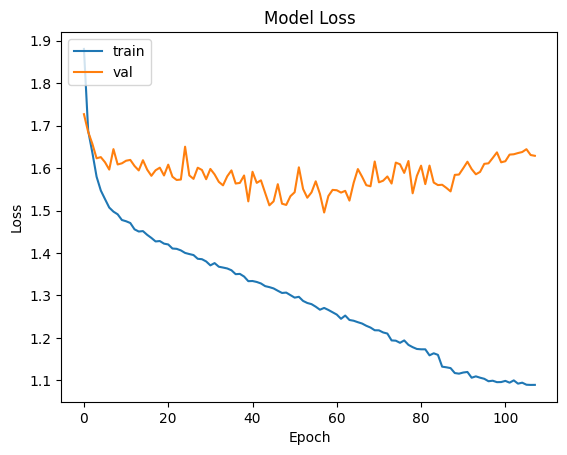

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

70/70 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.53      0.61      0.56       374
           1       0.69      0.66      0.67       406
           2       0.48      0.49      0.49       374
           3       0.42      0.26      0.32       372
           4       0.42      0.47      0.44       376
           5       0.45      0.52      0.48       331

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.49      2233
weighted avg       0.50      0.50      0.50      2233



val accuracy: 50.957852602005005
train accuracy: 63.99891972541809
test accuracy 50.20152261531572




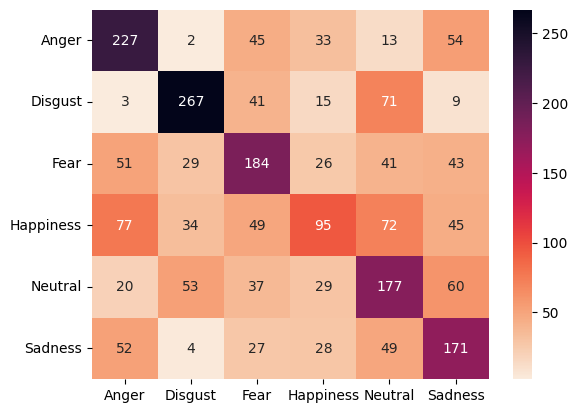

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(features_aug), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

model 2

In [ ]:
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model2.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model2.add(layers.Dropout(0.4))

model2.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model2.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model2.add(layers.Dropout(0.4))

model2.add(layers.Conv1D(256, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0), input_shape=(features_aug.shape[1],1)))
model2.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model2.add(layers.Dropout(0.4))



model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))

model2.add(layers.Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 159, 512)          3072      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 78, 512)          0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 78, 512)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 74, 512)           1311232   
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 35, 512)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 35, 512)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history2 = model2.fit(np.array(features_aug),np.array(labels_train1D),batch_size=32,epochs=200,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model2.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/200
464/464 [==============================] - 31s 63ms/step - loss: 1.8898 - accuracy: 0.2131 - val_loss: 1.7206 - val_accuracy: 0.2835 - lr: 1.0000e-04
Epoch 2/200
464/464 [==============================] - 30s 64ms/step - loss: 1.6778 - accuracy: 0.2687 - val_loss: 1.6793 - val_accuracy: 0.3027 - lr: 1.0000e-04
Epoch 3/200
464/464 [==============================] - 29s 63ms/step - loss: 1.6236 - accuracy: 0.2985 - val_loss: 1.6479 - val_accuracy: 0.3103 - lr: 1.0000e-04
Epoch 4/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5754 - accuracy: 0.3339 - val_loss: 1.6257 - val_accuracy: 0.3142 - lr: 1.0000e-04
Epoch 5/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5435 - accuracy: 0.3555 - val_loss: 1.6465 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 6/200
464/464 [==============================] - 29s 63ms/step - loss: 1.5238 - accuracy: 0.3622 - val_loss: 1.6349 - val_accuracy: 0.3410 - lr: 1.0000e-04
Epoch 7/200
464/464 [=======

70/70 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       374
           1       0.67      0.67      0.67       406
           2       0.51      0.48      0.49       374
           3       0.42      0.28      0.33       372
           4       0.41      0.43      0.42       376
           5       0.45      0.54      0.49       331

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.50      2233
weighted avg       0.50      0.50      0.50      2233



val accuracy: 45.59386968612671
train accuracy: 64.89490866661072
test accuracy 50.3358710255262




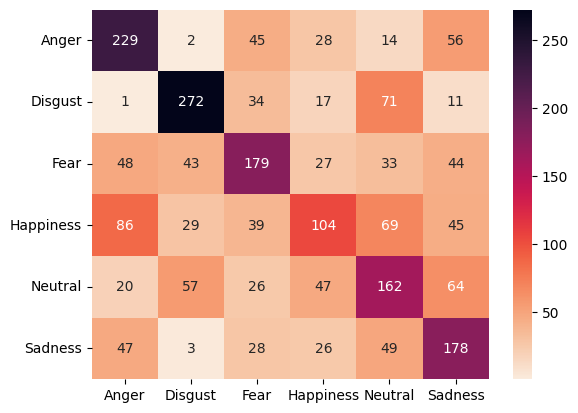

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model2.evaluate(np.array(features_aug), np.array(labels_train1D), verbose=0)
y_pred = model2.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

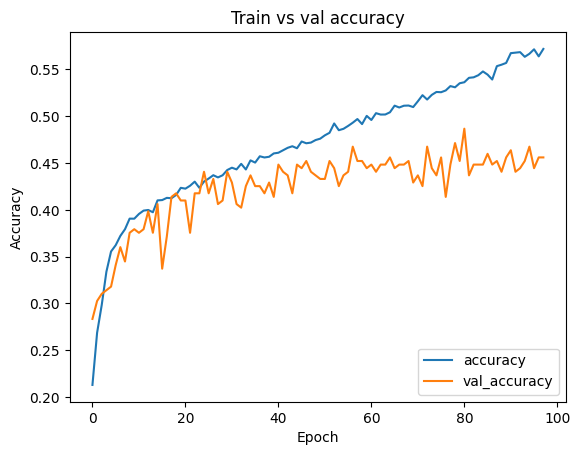

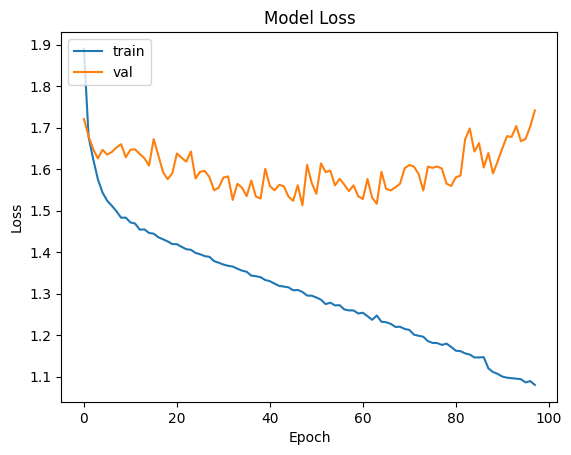

In [ ]:
plt.plot(model_history2.history['accuracy'], label='accuracy')
plt.plot(model_history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Train vs val accuracy")
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
model_history2 = model2.fit(np.array(features_aug),np.array(labels_train1D),batch_size=32,epochs=20,validation_data=(np.array(features_val), np.array(labels_val1D)), callbacks=[rlrp,es])
score, acc = model2.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('\nVal accuracy:', acc)

Epoch 1/20
464/464 [==============================] - 29s 63ms/step - loss: 1.0318 - accuracy: 0.5929 - val_loss: 1.7607 - val_accuracy: 0.4598 - lr: 1.0000e-05
Epoch 2/20
464/464 [==============================] - 29s 63ms/step - loss: 1.0255 - accuracy: 0.5933 - val_loss: 1.7770 - val_accuracy: 0.4636 - lr: 1.0000e-05
Epoch 3/20
464/464 [==============================] - 29s 63ms/step - loss: 1.0355 - accuracy: 0.5893 - val_loss: 1.7761 - val_accuracy: 0.4598 - lr: 1.0000e-05
Epoch 4/20
464/464 [==============================] - 29s 62ms/step - loss: 1.0238 - accuracy: 0.5928 - val_loss: 1.7606 - val_accuracy: 0.4559 - lr: 1.0000e-05
Epoch 5/20
464/464 [==============================] - 29s 63ms/step - loss: 1.0236 - accuracy: 0.5926 - val_loss: 1.7696 - val_accuracy: 0.4636 - lr: 1.0000e-05
Epoch 6/20
464/464 [==============================] - 29s 63ms/step - loss: 1.0288 - accuracy: 0.5942 - val_loss: 1.7688 - val_accuracy: 0.4598 - lr: 1.0000e-05
Epoch 7/20
464/464 [==============

70/70 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       374
           1       0.68      0.70      0.69       406
           2       0.50      0.50      0.50       374
           3       0.43      0.29      0.35       372
           4       0.43      0.45      0.44       376
           5       0.44      0.54      0.49       331

    accuracy                           0.51      2233
   macro avg       0.51      0.51      0.50      2233
weighted avg       0.51      0.51      0.51      2233



val accuracy: 47.12643623352051
train accuracy: 69.28725242614746
test accuracy 51.231527093596064




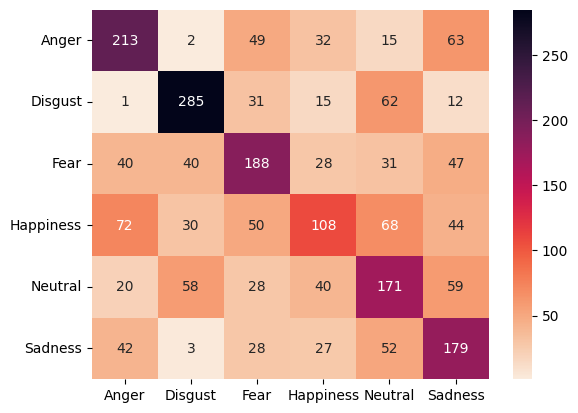

In [ ]:
score, trainacc = model2.evaluate(np.array(features_aug), np.array(labels_train1D), verbose=0)
y_pred = model2.predict(features_test)
report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)
print("\n")

###2D Models

In [ ]:
import tensorflow as tf

# Check if GPU is available
if not tf.test.gpu_device_name():
    print("GPU device not found")
else:
    print("GPU device found")
# Create a TensorFlow session with GPU memory growth enabled
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

GPU device found


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
def create_mel_spectrograms(audio_list):
    mel_spectrograms = []
    for i in range(len(audio_list)):
        audio = audio_list[i]
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spectrograms.append(mel_spec_db)
    return np.array(mel_spectrograms)

In [ ]:
train_data, test_data, labels_train2D, labels_test2D = train_test_split(Audio_List,Labels, test_size=0.30, random_state=42)
train_data,val_data, labels_train2D, labels_val2D = train_test_split(train_data,labels_train2D, test_size=0.05, random_state=42)
print(len(train_data))
print(len(val_data))
print(len(test_data))

4948
261
2233


In [ ]:
train_data = create_mel_spectrograms(train_data)
val_data = create_mel_spectrograms(val_data)
test_data = create_mel_spectrograms(test_data)

In [ ]:
labels_train2D = np.array(labels_train2D)
labels_test2D = np.array(labels_test2D)
labels_val2D = np.array(labels_val2D)

In [ ]:
# Add an extra dimension to represent the number of channels (in this case, 1)
train_data_processed = np.expand_dims(train_data, axis=-1)
validation_data_processed = np.expand_dims(val_data, axis=-1)
test_data_processed = np.expand_dims(test_data, axis=-1)

#### model 1

In [ ]:
model = Sequential()

model.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model.add(Conv2D(512, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 61, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 27, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 23, 128)       1638528   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 10, 128)       0

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 78s 319ms/step - loss: 9.6358 - accuracy: 0.2045 - val_loss: 1.6729 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 39s 252ms/step - loss: 1.6169 - accuracy: 0.3316 - val_loss: 1.6022 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 38s 244ms/step - loss: 1.5567 - accuracy: 0.3616 - val_loss: 1.6664 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 38s 243ms/step - loss: 1.5159 - accuracy: 0.3789 - val_loss: 1.5320 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 38s 246ms/step - loss: 1.4445 - accuracy: 0.4119 - val_loss: 1.5633 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 37s 241ms/step - loss: 1.3984 - accuracy: 0.4404 - val_loss: 1.4902 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 7/100
155/155 [=========================

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 11s 153ms/step - loss: 1.3573 - accuracy: 0.4926
test loss = 1.3572748899459839
test accuracy = 0.4926108419895172


#### model 2

In [ ]:
model2 = Sequential()

model2.add(Conv2D(512, (7, 7), activation='relu', input_shape=train_data_processed.shape[1:]))
model2.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model2.add(Conv2D(512, (5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model2.add(Conv2D(128, (5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))

model2.add(Dense(6, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 122, 124, 512)     25600     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 59, 60, 512)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 55, 56, 512)       6554112   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 512)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       1638528   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 128)       

In [ ]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model2.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 69s 318ms/step - loss: 7.0480 - accuracy: 0.1582 - val_loss: 1.7931 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 37s 236ms/step - loss: 1.7907 - accuracy: 0.1663 - val_loss: 1.7955 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 37s 239ms/step - loss: 1.7903 - accuracy: 0.1756 - val_loss: 1.7975 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 37s 236ms/step - loss: 1.7901 - accuracy: 0.1744 - val_loss: 1.7987 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 36s 234ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7996 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 36s 233ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7996 - val_accuracy: 0.1226 - lr: 0.0010


In [ ]:
test_loss, test_accuracy = model2.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 11s 154ms/step - loss: 1.7904 - accuracy: 0.1657
test loss = 1.7904382944107056
test accuracy = 0.16569636762142181


#### model 3


In [ ]:
model3 = Sequential()

model3.add(Conv2D(512, (3, 3), activation='relu', input_shape=train_data_processed.shape[1:]))
model3.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model3.add(Conv2D(512, (5, 5), activation='relu'))
model3.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model3.add(Conv2D(128, (5, 5), activation='relu'))
model3.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))

model3.add(Dense(6, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 128, 512)     5120      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 62, 512)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 58, 512)       6554112   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 27, 27, 512)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 128)       1638528   
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)     

In [ ]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model3.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 73s 330ms/step - loss: 7.5248 - accuracy: 0.1641 - val_loss: 1.7945 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 38s 246ms/step - loss: 1.7904 - accuracy: 0.1673 - val_loss: 1.7977 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 37s 242ms/step - loss: 1.7901 - accuracy: 0.1704 - val_loss: 1.7994 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 38s 246ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.8002 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 38s 246ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.8005 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 38s 246ms/step - loss: 1.7898 - accuracy: 0.1756 - val_loss: 1.8005 - val_accuracy: 0.1226 - lr: 4.0000e-04


In [ ]:
test_loss, test_accuracy = model3.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 11s 164ms/step - loss: 1.7904 - accuracy: 0.1657
test loss = 1.7904163599014282
test accuracy = 0.16569636762142181


#### model 4

In [ ]:
model4 = Sequential()

model4.add(Conv2D(512, (7, 7), activation='relu', input_shape=train_data_processed.shape[1:]))
model4.add(MaxPooling2D(pool_size = (7, 7),strides=2))

model4.add(Conv2D(512, (5, 5), activation='relu'))
model4.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model4.add(Conv2D(128, (5, 5), activation='relu'))
model4.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model4.add(Flatten())

model4.add(Dense(256, activation='relu'))

model4.add(Dense(6, activation='softmax'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 122, 124, 512)     25600     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 58, 59, 512)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 54, 55, 512)       6554112   
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 26, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 22, 128)       1638528   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 9, 9, 128)       

In [ ]:
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model4.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 67s 307ms/step - loss: 9.2312 - accuracy: 0.1742 - val_loss: 1.7953 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 35s 227ms/step - loss: 1.7904 - accuracy: 0.1756 - val_loss: 1.7983 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 36s 230ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7998 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 35s 226ms/step - loss: 1.7900 - accuracy: 0.1726 - val_loss: 1.8003 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 35s 227ms/step - loss: 1.7901 - accuracy: 0.1708 - val_loss: 1.8001 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 36s 229ms/step - loss: 1.7898 - accuracy: 0.1756 - val_loss: 1.8003 - val_accuracy: 0.1226 - lr: 4.0000e-04


In [ ]:
test_loss, test_accuracy = model4.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 10s 145ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.7904961109161377
test accuracy = 0.16569636762142181


#### model 5

In [ ]:
model5 = Sequential()

model5.add(Conv2D(512, (3, 3), activation='relu', input_shape=train_data_processed.shape[1:]))
model5.add(MaxPooling2D(pool_size = (3, 3),strides=2))

model5.add(Conv2D(512, (5, 5), activation='relu'))
model5.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model5.add(Conv2D(128, (5, 5), activation='relu'))
model5.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model5.add(Flatten())

model5.add(Dense(256, activation='relu'))

model5.add(Dense(6, activation='softmax'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 128, 512)     5120      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 63, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 58, 59, 512)       6554112   
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 27, 28, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 23, 24, 128)       1638528   
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 128)     

In [ ]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model5.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 71s 321ms/step - loss: 8.2342 - accuracy: 0.1742 - val_loss: 1.7942 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 36s 235ms/step - loss: 1.7906 - accuracy: 0.1728 - val_loss: 1.7964 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 37s 237ms/step - loss: 1.7901 - accuracy: 0.1716 - val_loss: 1.7983 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 36s 235ms/step - loss: 1.7900 - accuracy: 0.1712 - val_loss: 1.7995 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 37s 237ms/step - loss: 1.7900 - accuracy: 0.1742 - val_loss: 1.8003 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 36s 233ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.8004 - val_accuracy: 0.1226 - lr: 0.0010


In [ ]:
test_loss, test_accuracy = model5.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 10s 142ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.7904525995254517
test accuracy = 0.16569636762142181


#### model 6

In [ ]:
model6 = Sequential()

model6.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model6.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model6.add(Conv2D(512, (5, 5), activation='relu'))
model6.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model6.add(Conv2D(512, (5, 5), activation='relu'))
model6.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model6.add(Conv2D(128, (5, 5), activation='relu'))
model6.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model6.add(Flatten())

model6.add(Dense(256, activation='relu'))

model6.add(Dense(6, activation='softmax'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 27, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 23, 512)       6554112   
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 9, 10, 512)      

In [ ]:
model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model6.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 50s 290ms/step - loss: 5.9380 - accuracy: 0.1823 - val_loss: 1.7933 - val_accuracy: 0.1533 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 42s 269ms/step - loss: 1.7692 - accuracy: 0.2144 - val_loss: 1.7752 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 42s 272ms/step - loss: 1.6916 - accuracy: 0.2759 - val_loss: 1.6717 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 42s 273ms/step - loss: 1.5566 - accuracy: 0.3476 - val_loss: 1.5255 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 42s 269ms/step - loss: 1.5095 - accuracy: 0.3814 - val_loss: 1.4586 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 42s 268ms/step - loss: 1.4626 - accuracy: 0.4038 - val_loss: 1.4192 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 7/100
155/155 [=========================

In [ ]:
test_loss, test_accuracy = model6.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 7s 94ms/step - loss: 1.4019 - accuracy: 0.4711
test loss = 1.4019180536270142
test accuracy = 0.4711150825023651


#### model 7

In [ ]:
model7 = Sequential()

model7.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model7.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model7.add(Conv2D(512, (5, 5), activation='relu'))
model7.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model7.add(Conv2D(128, (5, 5), activation='relu'))
model7.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model7.add(Conv2D(128, (5, 5), activation='relu'))
model7.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model7.add(Flatten())

model7.add(Dense(256, activation='relu'))

model7.add(Dense(6, activation='softmax'))

model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 27, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 22, 23, 128)       1638528   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 9, 10, 128)      

In [ ]:
model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model7.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 42s 254ms/step - loss: 2.9147 - accuracy: 0.1758 - val_loss: 1.7952 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 37s 241ms/step - loss: 1.7905 - accuracy: 0.1756 - val_loss: 1.7993 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 38s 242ms/step - loss: 1.7901 - accuracy: 0.1756 - val_loss: 1.8016 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 37s 239ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7998 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 37s 242ms/step - loss: 1.7901 - accuracy: 0.1756 - val_loss: 1.7995 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 38s 242ms/step - loss: 1.7902 - accuracy: 0.1744 - val_loss: 1.8025 - val_accuracy: 0.1226 - lr: 0.0010


In [ ]:
test_loss, test_accuracy = model7.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 6s 78ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.7905296087265015
test accuracy = 0.16569636762142181


#### model 8

In [ ]:
model8 = Sequential()

model8.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model8.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model8.add(Conv2D(512, (5, 5), activation='relu'))
model8.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model8.add(Conv2D(256, (5, 5), activation='relu'))
model8.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model8.add(Conv2D(128, (5, 5), activation='relu'))
model8.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model8.add(Flatten())

model8.add(Dense(256, activation='relu'))

model8.add(Dense(6, activation='softmax'))

model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 26, 27, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 23, 256)       3277056   
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 9, 10, 256)      

In [ ]:
model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model8.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 47s 271ms/step - loss: 3.0360 - accuracy: 0.1793 - val_loss: 1.7877 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 40s 257ms/step - loss: 1.7214 - accuracy: 0.2510 - val_loss: 1.6539 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 40s 255ms/step - loss: 1.5820 - accuracy: 0.3531 - val_loss: 1.5162 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 40s 256ms/step - loss: 1.4959 - accuracy: 0.3771 - val_loss: 1.4635 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 39s 251ms/step - loss: 1.4590 - accuracy: 0.4018 - val_loss: 1.4223 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 40s 256ms/step - loss: 1.4031 - accuracy: 0.4371 - val_loss: 1.3957 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 7/100
155/155 [=========================

In [ ]:
test_loss, test_accuracy = model8.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 6s 87ms/step - loss: 1.3479 - accuracy: 0.5007
test loss = 1.3479043245315552
test accuracy = 0.5006717443466187


#### model 9

In [ ]:
model9 = Sequential()

model9.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))

model9.add(Conv2D(512, (5, 5), activation='relu'))
model9.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model9.add(Conv2D(256, (5, 5), activation='relu'))
model9.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model9.add(Conv2D(128, (5, 5), activation='relu'))
model9.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model9.add(Flatten())

model9.add(Dense(256, activation='relu'))

model9.add(Dense(6, activation='softmax'))

model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 126, 512)     13312     
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 122, 512)     6554112   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 59, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 55, 256)       3277056   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 26, 256)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 22, 128)       8

In [ ]:
model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model9.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 294s 1s/step - loss: 7.6615 - accuracy: 0.1627 - val_loss: 1.7933 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 131s 848ms/step - loss: 1.7906 - accuracy: 0.1746 - val_loss: 1.7960 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 134s 863ms/step - loss: 1.7901 - accuracy: 0.1712 - val_loss: 1.7979 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 134s 862ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7997 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 132s 849ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.7995 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 134s 863ms/step - loss: 1.7899 - accuracy: 0.1712 - val_loss: 1.7996 - val_accuracy: 0.1226 - lr: 0.0010


In [ ]:
test_loss, test_accuracy = model9.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 47s 669ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.790515422821045
test accuracy = 0.16569636762142181


#### model 10

In [ ]:
model10 = Sequential()

model10.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model10.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model10.add(Conv2D(512, (5, 5), activation='relu'))

model10.add(Conv2D(256, (5, 5), activation='relu'))
model10.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model10.add(Conv2D(128, (5, 5), activation='relu'))

model10.add(Conv2D(64, (5, 5), activation='relu'))
model10.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model10.add(Flatten())

model10.add(Dense(256, activation='relu'))

model10.add(Dense(6, activation='softmax'))

model10.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 conv2d_36 (Conv2D)          (None, 52, 53, 256)       3277056   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 25, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 21, 128)      

In [ ]:
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model10.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 96s 421ms/step - loss: 3.6099 - accuracy: 0.1702 - val_loss: 1.7968 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 47s 304ms/step - loss: 1.7903 - accuracy: 0.1756 - val_loss: 1.7979 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 47s 305ms/step - loss: 1.7901 - accuracy: 0.1756 - val_loss: 1.7992 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 47s 304ms/step - loss: 1.7899 - accuracy: 0.1684 - val_loss: 1.8002 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 48s 307ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.8000 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 47s 306ms/step - loss: 1.7900 - accuracy: 0.1734 - val_loss: 1.8006 - val_accuracy: 0.1226 - lr: 0.0010


In [ ]:
test_loss, test_accuracy = model10.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 15s 217ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.7904764413833618
test accuracy = 0.16569636762142181


#### model 11

In [ ]:
model11 = Sequential()

model11.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model11.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model11.add(Conv2D(512, (5, 5), activation='relu'))
model11.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model11.add(Conv2D(64, (5, 5), activation='relu'))
model11.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model11.add(Flatten())

model11.add(Dense(256, activation='relu'))

model11.add(Dense(6, activation='softmax'))

model11.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 26, 27, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 22, 23, 64)        819264    
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 9, 10, 64)      

In [ ]:
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model10.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 51s 311ms/step - loss: 1.7900 - accuracy: 0.1730 - val_loss: 1.8008 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 47s 301ms/step - loss: 1.7901 - accuracy: 0.1694 - val_loss: 1.8018 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 47s 306ms/step - loss: 1.7900 - accuracy: 0.1756 - val_loss: 1.8003 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 47s 305ms/step - loss: 1.7899 - accuracy: 0.1756 - val_loss: 1.8005 - val_accuracy: 0.1226 - lr: 4.0000e-04
Epoch 5/100
155/155 [==============================] - 47s 306ms/step - loss: 1.7898 - accuracy: 0.1756 - val_loss: 1.8005 - val_accuracy: 0.1226 - lr: 4.0000e-04
Epoch 6/100
155/155 [==============================] - 47s 306ms/step - loss: 1.7899 - accuracy: 0.1756 - val_loss: 1.8006 - val_accuracy: 0.1226 - lr: 4.0000e-04
Epoch 7/100
155/155 [=============

In [ ]:
test_loss, test_accuracy = model10.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 7s 98ms/step - loss: 1.7904 - accuracy: 0.1657
test loss = 1.790417194366455
test accuracy = 0.16569636762142181


#### model 12


In [ ]:
model12 = Sequential()

model12.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model12.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model12.add(Conv2D(512, (5, 5), activation='relu'))
model12.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model12.add(Conv2D(256, (5, 5), activation='relu'))
model12.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model12.add(Flatten())

model12.add(Dense(256, activation='relu'))

model12.add(Dense(6, activation='softmax'))

model12.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 27, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 23, 256)       3277056   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 9, 10, 256)      

In [ ]:
model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model12.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 43s 265ms/step - loss: 11.0637 - accuracy: 0.2086 - val_loss: 1.6733 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 40s 256ms/step - loss: 1.6012 - accuracy: 0.3300 - val_loss: 1.6014 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 40s 258ms/step - loss: 1.5204 - accuracy: 0.3822 - val_loss: 1.4668 - val_accuracy: 0.4406 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 39s 255ms/step - loss: 1.4301 - accuracy: 0.4264 - val_loss: 1.5043 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 40s 259ms/step - loss: 1.3506 - accuracy: 0.4527 - val_loss: 1.5064 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 40s 255ms/step - loss: 1.3188 - accuracy: 0.4768 - val_loss: 1.3986 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 7/100
155/155 [========================

In [ ]:
test_loss, test_accuracy = model12.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 11s 159ms/step - loss: 1.5152 - accuracy: 0.4899
test loss = 1.5151822566986084
test accuracy = 0.4899238646030426


#### model 13 (best result)


In [ ]:
model13 = Sequential()

model13.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model13.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model13.add(Conv2D(512, (5, 5), activation='relu'))
model13.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model13.add(Conv2D(512, (5, 5), activation='relu'))
model13.add(MaxPooling2D(pool_size = (5, 5),strides=2))


model13.add(Flatten())

model13.add(Dense(256, activation='relu'))

model13.add(Dense(6, activation='softmax'))

model13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 61, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 57, 512)       6554112   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 27, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 23, 512)       6554112   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 10, 512)       0

In [ ]:
model13.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model13.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 82s 375ms/step - loss: 16.9891 - accuracy: 0.2357 - val_loss: 1.5522 - val_accuracy: 0.3563 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 42s 272ms/step - loss: 1.4998 - accuracy: 0.3953 - val_loss: 1.6433 - val_accuracy: 0.3180 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 42s 270ms/step - loss: 1.4466 - accuracy: 0.4149 - val_loss: 1.4561 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 42s 272ms/step - loss: 1.3630 - accuracy: 0.4513 - val_loss: 1.3773 - val_accuracy: 0.4559 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 42s 272ms/step - loss: 1.2845 - accuracy: 0.4873 - val_loss: 1.3992 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 42s 269ms/step - loss: 1.2171 - accuracy: 0.5121 - val_loss: 1.3482 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 7/100
155/155 [========================

In [ ]:
test_loss, test_accuracy = model13.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 12s 169ms/step - loss: 1.4933 - accuracy: 0.5208
test loss = 1.4932711124420166
test accuracy = 0.5208240151405334


70/70 [==============================] - 6s 85ms/step
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       370
           1       0.63      0.71      0.67       401
           2       0.47      0.36      0.41       376
           3       0.43      0.42      0.42       375
           4       0.49      0.46      0.47       388
           5       0.58      0.64      0.61       323

    accuracy                           0.52      2233
   macro avg       0.52      0.52      0.52      2233
weighted avg       0.52      0.52      0.52      2233



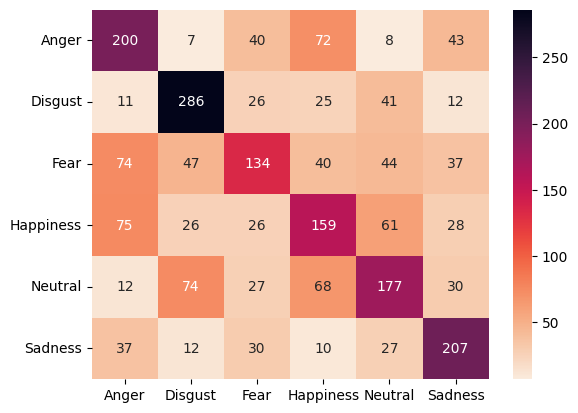

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model13.evaluate(train_data_processed, labels_train2D, verbose=0)
y_pred = model13.predict(test_data_processed)
report=metrics.classification_report(labels_test2D,np.argmax(y_pred,axis=1))
print(report)
matrix = metrics.confusion_matrix(labels_test2D ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

#### model 14

In [ ]:
model14 = Sequential()

model14.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model14.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model14.add(Conv2D(512, (5, 5), activation='relu'))

model14.add(Conv2D(512, (5, 5), activation='relu'))
model14.add(MaxPooling2D(pool_size = (5, 5),strides=2))


model14.add(Flatten())

model14.add(Dense(256, activation='relu'))

model14.add(Dense(6, activation='softmax'))

model14.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 56, 57, 512)       6554112   
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 53, 512)       6554112   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 25, 512)      0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 307200)           

In [ ]:
model14.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model14.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 85s 443ms/step - loss: 110.7225 - accuracy: 0.1797 - val_loss: 1.7938 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 57s 369ms/step - loss: 1.7894 - accuracy: 0.1778 - val_loss: 1.7972 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 57s 366ms/step - loss: 1.7902 - accuracy: 0.1720 - val_loss: 1.7989 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 56s 364ms/step - loss: 1.7901 - accuracy: 0.1756 - val_loss: 1.7994 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 57s 365ms/step - loss: 1.7899 - accuracy: 0.1756 - val_loss: 1.7998 - val_accuracy: 0.1226 - lr: 4.0000e-04
Epoch 6/100
155/155 [==============================] - 57s 366ms/step - loss: 1.7898 - accuracy: 0.1756 - val_loss: 1.7998 - val_accuracy: 0.1226 - lr: 4.0000e-04


In [ ]:
test_loss, test_accuracy = model14.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 12s 176ms/step - loss: 1.7905 - accuracy: 0.1657
test loss = 1.7905300855636597
test accuracy = 0.16569636762142181


#### model 15


In [ ]:
model15 = Sequential()

model15.add(Conv2D(512, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))
model15.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model15.add(Conv2D(1024, (5, 5), activation='relu'))
model15.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model15.add(Conv2D(512, (5, 5), activation='relu'))
model15.add(MaxPooling2D(pool_size = (5, 5),strides=2))


model15.add(Flatten())

model15.add(Dense(256, activation='relu'))

model15.add(Dense(6, activation='softmax'))

model15.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 124, 126, 512)     13312     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 60, 61, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 56, 57, 1024)      13108224  
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 27, 1024)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 22, 23, 512)       13107712  
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 9, 10, 512)      

In [ ]:
model15.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model15.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
155/155 [==============================] - 142s 639ms/step - loss: 56.2649 - accuracy: 0.2344 - val_loss: 1.5649 - val_accuracy: 0.3563 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 69s 446ms/step - loss: 1.5373 - accuracy: 0.3737 - val_loss: 1.5100 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 69s 447ms/step - loss: 1.4580 - accuracy: 0.4133 - val_loss: 1.5217 - val_accuracy: 0.3755 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 69s 447ms/step - loss: 1.3966 - accuracy: 0.4398 - val_loss: 1.5402 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 69s 446ms/step - loss: 1.3799 - accuracy: 0.4436 - val_loss: 1.4634 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 69s 446ms/step - loss: 1.3235 - accuracy: 0.4679 - val_loss: 1.4916 - val_accuracy: 0.4406 - lr: 0.0010
Epoch 7/100
155/155 [=======================

In [ ]:
test_loss, test_accuracy = model15.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 22s 311ms/step - loss: 1.6184 - accuracy: 0.4877
test loss = 1.618430256843567
test accuracy = 0.4876847267150879


#### model 16

In [ ]:
model16 = Sequential()

model16.add(Conv2D(1024, (5, 5), activation='relu', input_shape=train_data_processed.shape[1:]))

model16.add(Conv2D(1024, (5, 5), activation='relu'))
model16.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model16.add(Conv2D(512, (5, 5), activation='relu'))

model16.add(Conv2D(512, (5, 5), activation='relu'))
model16.add(MaxPooling2D(pool_size = (5, 5),strides=2))

model16.add(Conv2D(256, (5, 5), activation='relu'))

model16.add(Conv2D(256, (5, 5), activation='relu'))
model16.add(MaxPooling2D(pool_size = (5, 5),strides=2))


model16.add(Flatten())

model16.add(Dense(256, activation='relu'))

model16.add(Dense(64, activation='relu'))

model16.add(Dense(6, activation='softmax'))

model16.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 124, 126, 1024)    26624     
                                                                 
 conv2d_30 (Conv2D)          (None, 120, 122, 1024)    26215424  
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 58, 59, 1024)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 54, 55, 512)       13107712  
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 51, 512)       6554112   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 23, 24, 512)      0         
 g2D)                                                 

In [ ]:
model16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.00001)

model16.fit(train_data_processed, labels_train2D, validation_data=(validation_data_processed, labels_val2D), epochs=100, batch_size=32,callbacks=[rlrp,es])

Epoch 1/100
 31/155 [=====>........................] - ETA: 34:11 - loss: 558.0549 - accuracy: 0.1643

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_accuracy = model16.evaluate(test_data_processed, labels_test2D)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_accuracy}")

70/70 [==============================] - 9s 125ms/step - loss: 1.7904 - accuracy: 0.1657
test loss = 1.7904365062713623
test accuracy = 0.16569636762142181
